# Linear Regression Model

This notebook trains a basic linear regression model for house price prediction.

## What we will do:
1. Load preprocessed data
2. Split data into training and testing sets
3. Train linear regression model
4. Evaluate performance with cross validation
5. Analyze model results
6. Summary and next steps


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


## 1. Load Preprocessed Data


In [3]:
# Load the linear regression ready dataset
df = pd.read_pickle('../../data/processed/df_linear_ready.pkl')

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nTarget variable (SalePrice) statistics:")
print(f"Mean: ${df['SalePrice'].mean():,.4f}")
print(f"Std:  ${df['SalePrice'].std():,.4f}")
print(f"Min:  ${df['SalePrice'].min():,.4f}")
print(f"Max:  ${df['SalePrice'].max():,.4f}")

# Check data types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {len(numeric_cols)}")
print("First 5 rows:")
df.head()


Dataset shape: (1408, 25)
Missing values: 0

Target variable (SalePrice) statistics:
Mean: $12.0115
Std:  $0.3729
Min:  $10.8590
Max:  $13.0213

Numeric columns: 25
First 5 rows:


,Quality_x_TotalSF,Garage_x_Quality,Bath_x_Area,GrLivArea,GarageArea,YearBuilt,FullBath,EffectiveAge,Fireplaces,MasVnrArea,TotRmsAbvGrd,HouseAge,GarageCars,TotalSF,Quality_x_Area,1stFlrSF,TotalBathrooms,TotalBsmtSF,AvgRoomSize,YearRemodAdd,LotArea,TotalPorchSF,BsmtFinSF1,OpenPorchSF,SalePrice
0,0.432664,0.441366,0.939674,0.579237,0.388071,1.050559,0.830711,-0.872044,-0.943851,1.238864,0.974210,-1.050559,0.335509,0.062565,0.710286,-0.803482,1.715172,-0.460221,-0.196912,0.880544,-0.288099,-0.574060,0.671268,0.860499,12.247699
1,0.055847,0.123167,0.039047,-0.381098,-0.034660,0.155709,0.830711,0.389666,0.655357,-0.817377,-0.300001,-0.155709,0.335509,0.003988,-0.258243,0.475000,0.408728,0.577620,-0.456542,-0.429161,0.035223,0.879089,1.322053,-1.063457,12.109016
2,0.553566,0.441366,1.021029,0.719624,0.676296,0.984273,0.830711,-0.823516,0.655357,1.202225,-0.300001,-0.984273,0.335509,0.257822,0.806931,-0.567321,1.715172,-0.296620,1.544138,0.832036,0.499121,-0.777208,0.144898,0.687919,12.317171
3,0.349667,1.555065,-0.529393,0.592394,0.839624,-1.865989,-1.031775,0.632302,0.655357,-0.817377,0.337105,1.865989,1.689080,-0.067141,0.719330,-0.424225,-0.244494,-0.715847,0.461232,-0.720207,0.021166,0.918947,-0.501102,0.604263,11.849405
4,1.382377,2.032364,1.425408,1.400056,1.771554,0.951131,0.830711,-0.726462,0.655357,1.340541,1.611316,-0.951131,1.689080,1.146242,1.594776,0.152934,1.715172,0.278538,0.599542,0.735021,1.345383,0.779056,0.549246,1.009615,12.429220


## 2. Prepare Data for Training


In [4]:
# Prepare features and target
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {len(X.columns)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")


Features shape: (1408, 24)
Target shape: (1408,)
Feature columns: 24

Training set: 1126 samples
Testing set: 282 samples
Train/Test ratio: 4.0:1


## 3. Train Linear Regression Model


In [5]:
# Initialize and train the linear regression model
linear_model = LinearRegression()

print("Training Linear Regression model...")
linear_model.fit(X_train, y_train)

# Make predictions
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

print("✓ Model training completed")
print(f"Model coefficients: {len(linear_model.coef_)} features")
print(f"Model intercept: ${linear_model.intercept_:,.4f}")


Training Linear Regression model...
✓ Model training completed
Model coefficients: 24 features
Model intercept: $12.0112


## 4. Cross Validation Performance


In [6]:
# Perform cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-fold cross validation...")
print("📝 Note: Metrics calculated on log-transformed target")

# Calculate cross validation scores for different metrics
cv_rmse_scores = []
cv_mae_scores = []
cv_r2_scores = []
cv_rmse_original_scores = []
cv_mae_original_scores = []

for train_idx, val_idx in cv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model on fold
    model_fold = LinearRegression()
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Predict on validation fold
    y_val_pred = model_fold.predict(X_val_fold)
    
    # Calculate metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    mae_log = mean_absolute_error(y_val_fold, y_val_pred)
    r2_log = r2_score(y_val_fold, y_val_pred)
    
    # Calculate metrics on original scale (exp-transformed)
    y_val_original = np.exp(y_val_fold)
    y_val_pred_original = np.exp(y_val_pred)
    rmse_original = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_original = mean_absolute_error(y_val_original, y_val_pred_original)
    
    cv_rmse_scores.append(rmse_log)
    cv_mae_scores.append(mae_log)
    cv_r2_scores.append(r2_log)
    cv_rmse_original_scores.append(rmse_original)
    cv_mae_original_scores.append(mae_original)

# Display cross validation results
print("\n=== CROSS VALIDATION RESULTS ===")
print("Log-scale metrics (model's native scale):")
print(f"RMSE (log): {np.mean(cv_rmse_scores):.4f} ± {np.std(cv_rmse_scores):.4f}")
print(f"MAE (log):  {np.mean(cv_mae_scores):.4f} ± {np.std(cv_mae_scores):.4f}")
print(f"R²:         {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")

print("\nOriginal price scale metrics (for interpretation):")
print(f"RMSE: ${np.mean(cv_rmse_original_scores):,.4f} ± ${np.std(cv_rmse_original_scores):,.4f}")
print(f"MAE:  ${np.mean(cv_mae_original_scores):,.4f} ± ${np.std(cv_mae_original_scores):,.4f}")

# Store CV results for comparison
cv_results = {
    'RMSE_log_mean': np.mean(cv_rmse_scores),
    'RMSE_log_std': np.std(cv_rmse_scores),
    'MAE_log_mean': np.mean(cv_mae_scores),
    'MAE_log_std': np.std(cv_mae_scores),
    'R2_mean': np.mean(cv_r2_scores),
    'R2_std': np.std(cv_r2_scores),
    'RMSE_original_mean': np.mean(cv_rmse_original_scores),
    'RMSE_original_std': np.std(cv_rmse_original_scores),
    'MAE_original_mean': np.mean(cv_mae_original_scores),
    'MAE_original_std': np.std(cv_mae_original_scores)
}


Performing 5-fold cross validation...
📝 Note: Metrics calculated on log-transformed target

=== CROSS VALIDATION RESULTS ===
Log-scale metrics (model's native scale):
RMSE (log): 0.1283 ± 0.0085
MAE (log):  0.0920 ± 0.0062
R²:         0.8794 ± 0.0151

Original price scale metrics (for interpretation):
RMSE: $21,381.1688 ± $2,005.5908
MAE:  $15,182.0958 ± $1,205.7245


## 5. Test Set Performance


In [7]:
# Calculate test set performance
# Log scale metrics
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae_log = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Original scale metrics
y_test_original = np.exp(y_test)
y_test_pred_original = np.exp(y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
test_mae = mean_absolute_error(y_test_original, y_test_pred_original)

# Calculate training set performance for comparison
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae_log = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Original scale for training
y_train_original = np.exp(y_train)
y_train_pred_original = np.exp(y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)

print("=== FINAL MODEL PERFORMANCE ===")
print("\nTraining Set:")
print(f"RMSE (log): {train_rmse_log:.4f}")
print(f"MAE (log):  {train_mae_log:.4f}")
print(f"R²:         {train_r2:.4f}")
print(f"RMSE: ${train_rmse:,.0f}")
print(f"MAE:  ${train_mae:,.0f}")

print("\nTest Set:")
print(f"RMSE (log): {test_rmse_log:.4f}")
print(f"MAE (log):  {test_mae_log:.4f}")
print(f"R²:         {test_r2:.4f}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"MAE:  ${test_mae:,.0f}")

# Check for overfitting using log scale metrics
rmse_log_diff = train_rmse_log - test_rmse_log
r2_diff = train_r2 - test_r2

print(f"\nModel Stability:")
print(f"RMSE (log) difference (train-test): {rmse_log_diff:.4f}")
print(f"R² difference (train-test): {r2_diff:.4f}")
print(f"RMSE ($) difference (train-test): ${train_rmse - test_rmse:,.0f}")

if abs(rmse_log_diff) < 0.05 and abs(r2_diff) < 0.05:
    print("✓ Model shows good generalization")
else:
    print("⚠️ Model may be overfitting or underfitting")


=== FINAL MODEL PERFORMANCE ===

Training Set:
RMSE (log): 0.1255
MAE (log):  0.0898
R²:         0.8858
RMSE: $21,029
MAE:  $14,862

Test Set:
RMSE (log): 0.1240
MAE (log):  0.0853
R²:         0.8903
RMSE: $23,813
MAE:  $15,540

Model Stability:
RMSE (log) difference (train-test): 0.0015
R² difference (train-test): -0.0045
RMSE ($) difference (train-test): $-2,784
✓ Model shows good generalization


## 6. Model Analysis and Visualization


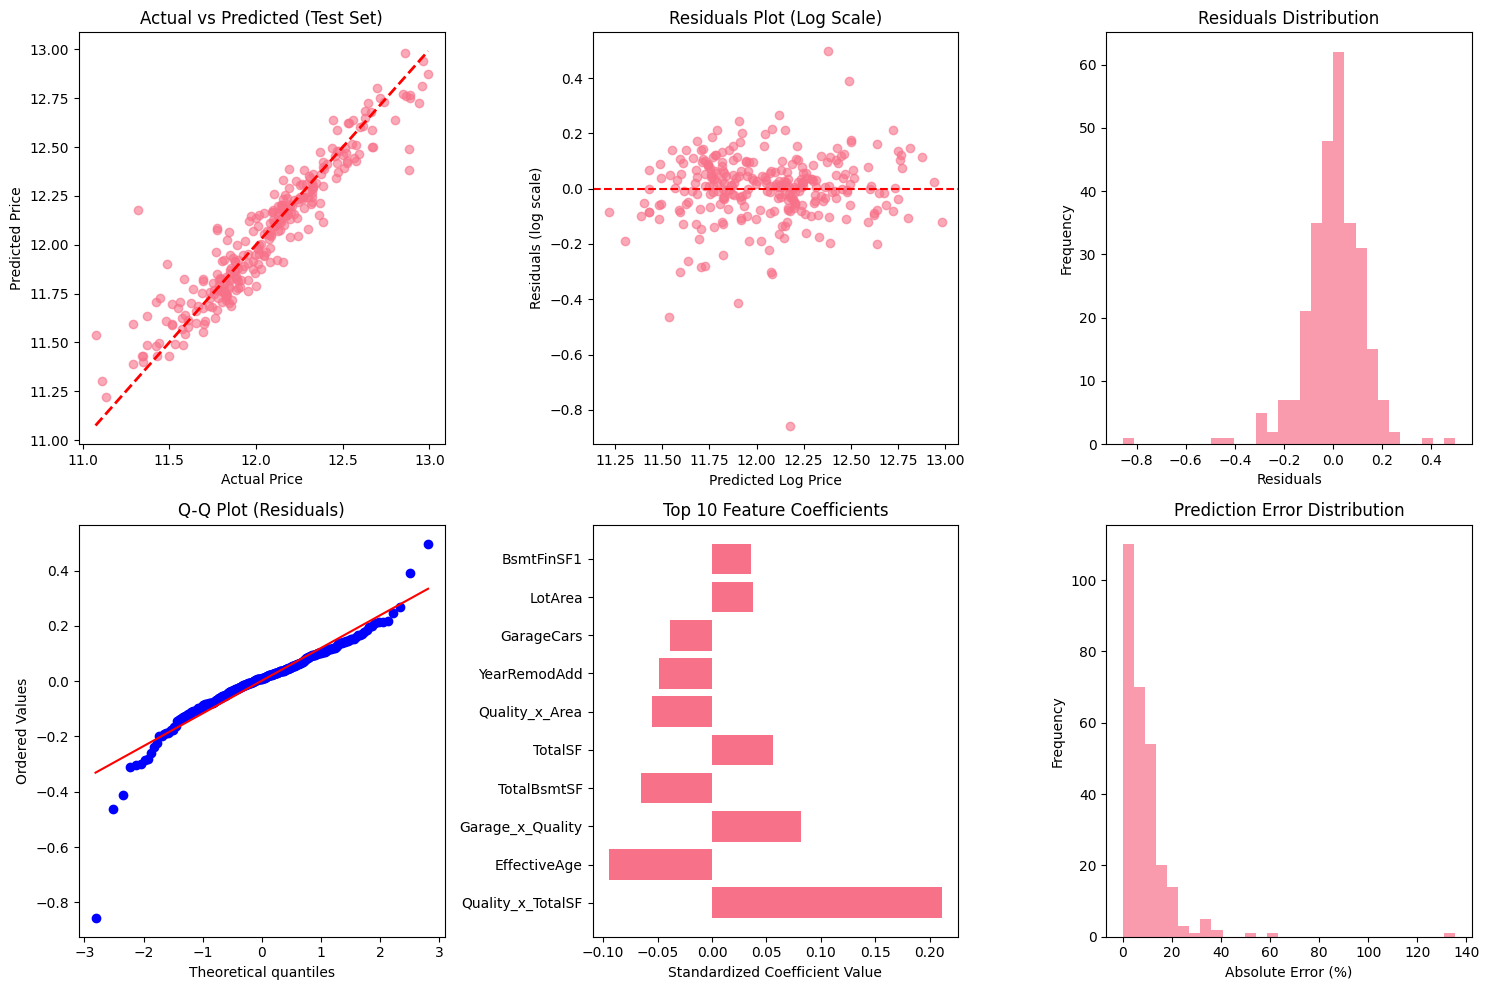


Residuals Analysis:
Log scale:
  Mean residual: 0.0016
  Std of residuals: 0.1242
  Median absolute error: 0.0626

Original price scale:
  Mean residual: $2,337.7389
  Std of residuals: $23,740.1117
  Median absolute error: $10,093.6044

Prediction Accuracy:
Within 10% error: 69.5% of predictions
Within 20% error: 92.6% of predictions


In [8]:
# Create visualizations for model analysis
plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted values
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted (Test Set)')

# 2. Residuals plot (log scale)
plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals (log scale)')
plt.title('Residuals Plot (Log Scale)')

# 3. Residuals histogram
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

# 4. Q-Q plot for residuals normality
from scipy import stats
plt.subplot(2, 3, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Residuals)')

# 5. Feature coefficients (top 10 by absolute value)
plt.subplot(2, 3, 5)
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': linear_model.coef_
})
coef_df['abs_coef'] = abs(coef_df['coefficient'])
top_coef = coef_df.nlargest(10, 'abs_coef')

plt.barh(range(len(top_coef)), top_coef['coefficient'])
plt.yticks(range(len(top_coef)), top_coef['feature'])
plt.xlabel('Standardized Coefficient Value')
plt.title('Top 10 Feature Coefficients')

# 6. Prediction error distribution (original scale)
plt.subplot(2, 3, 6)
# Calculate percentage error on original scale
original_residuals = y_test_original - y_test_pred_original
error_percent = abs(original_residuals) / y_test_original * 100
plt.hist(error_percent, bins=30, alpha=0.7)
plt.xlabel('Absolute Error (%)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')

plt.tight_layout()
plt.show()

# Print additional analysis
print(f"\nResiduals Analysis:")
print(f"Log scale:")
print(f"  Mean residual: {residuals.mean():.4f}")
print(f"  Std of residuals: {residuals.std():.4f}")
print(f"  Median absolute error: {np.median(abs(residuals)):.4f}")

print(f"\nOriginal price scale:")
print(f"  Mean residual: ${original_residuals.mean():,.4f}")
print(f"  Std of residuals: ${original_residuals.std():,.4f}")
print(f"  Median absolute error: ${np.median(abs(original_residuals)):,.4f}")

# Calculate percentage of predictions within certain error ranges
within_10pct = (error_percent <= 10).sum() / len(error_percent) * 100
within_20pct = (error_percent <= 20).sum() / len(error_percent) * 100

print(f"\nPrediction Accuracy:")
print(f"Within 10% error: {within_10pct:.1f}% of predictions")
print(f"Within 20% error: {within_20pct:.1f}% of predictions")


## 7. Feature Importance Analysis


=== FEATURE IMPORTANCE ANALYSIS ===

📝 Note: Features are standardized (mean=0, std=1) and target is log-transformed
    Coefficients = change in log(price) per 1 std dev change in feature

Coefficient interpretation:
- Coefficient of 0.1 ≈ 10.5% price increase per 1 std dev of feature
- Coefficient of -0.1 ≈ 9.5% price decrease per 1 std dev of feature

Top 10 features that INCREASE price (standardized coefficients):
 1. Quality_x_TotalSF: +0.2109 (~+23.5% per 1 std dev)
 2. Garage_x_Quality: +0.0820 (~+8.5% per 1 std dev)
 3. TotalSF: +0.0556 (~+5.7% per 1 std dev)
 4. LotArea: +0.0377 (~+3.8% per 1 std dev)
 5. BsmtFinSF1: +0.0354 (~+3.6% per 1 std dev)
 6. YearBuilt: +0.0265 (~+2.7% per 1 std dev)
 7. GarageArea: +0.0236 (~+2.4% per 1 std dev)
 8. Fireplaces: +0.0233 (~+2.4% per 1 std dev)
 9. GrLivArea: +0.0221 (~+2.2% per 1 std dev)
10. TotalPorchSF: +0.0179 (~+1.8% per 1 std dev)

Top 10 features that DECREASE price (standardized coefficients):
 1. EffectiveAge: -0.0944 (~-9.0% 

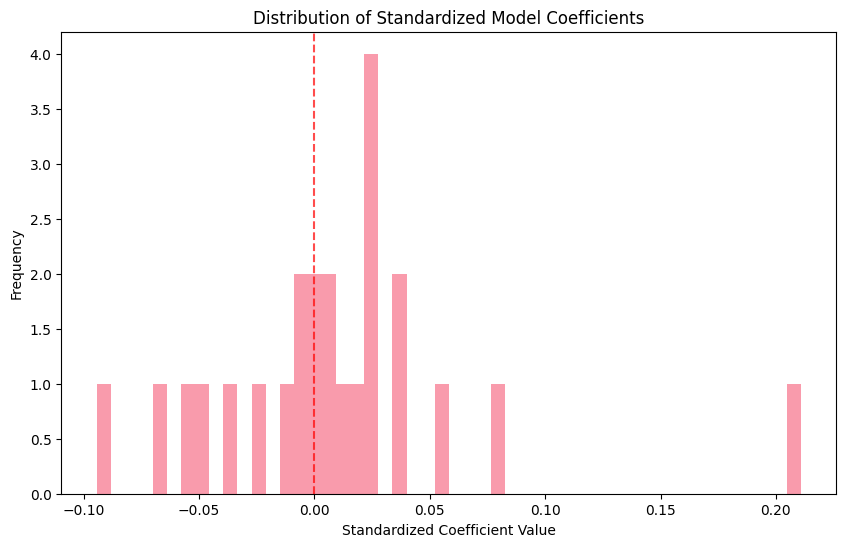

In [9]:
# Analyze feature coefficients for insights
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Since features are standardized and target is log-transformed,
# coefficients represent the change in log(price) per 1 standard deviation change in feature
print("\n📝 Note: Features are standardized (mean=0, std=1) and target is log-transformed")
print("    Coefficients = change in log(price) per 1 std dev change in feature")

# Calculate percentage change interpretation for log target
print("\nCoefficient interpretation:")
print("- Coefficient of 0.1 ≈ 10.5% price increase per 1 std dev of feature")
print("- Coefficient of -0.1 ≈ 9.5% price decrease per 1 std dev of feature")

# Top positive coefficients (features that increase price)
print("\nTop 10 features that INCREASE price (standardized coefficients):")
top_positive = coef_df[coef_df['coefficient'] > 0].nlargest(10, 'coefficient')
for i, (_, row) in enumerate(top_positive.iterrows(), 1):
    pct_change = (np.exp(row['coefficient']) - 1) * 100
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:+.4f} (~{pct_change:+.1f}% per 1 std dev)")

# Top negative coefficients (features that decrease price)
print("\nTop 10 features that DECREASE price (standardized coefficients):")
top_negative = coef_df[coef_df['coefficient'] < 0].nsmallest(10, 'coefficient')
for i, (_, row) in enumerate(top_negative.iterrows(), 1):
    pct_change = (np.exp(row['coefficient']) - 1) * 100
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:+.4f} (~{pct_change:+.1f}% per 1 std dev)")

# Summary statistics for coefficients
print(f"\nCoefficient Statistics:")
print(f"Number of positive coefficients: {(coef_df['coefficient'] > 0).sum()}")
print(f"Number of negative coefficients: {(coef_df['coefficient'] < 0).sum()}")
print(f"Largest positive coefficient: {coef_df['coefficient'].max():+.4f}")
print(f"Largest negative coefficient: {coef_df['coefficient'].min():+.4f}")
print(f"Mean absolute coefficient: {coef_df['abs_coef'].mean():.4f}")

# Check if coefficients are reasonable (not all zero)
if coef_df['abs_coef'].max() < 1e-10:
    print("⚠️ WARNING: All coefficients are essentially zero!")
    print("   This may indicate:")
    print("   - Perfect multicollinearity between features")
    print("   - Numerical precision issues")
    print("   - Data preprocessing problems")
else:
    print(f"✓ Coefficients range from {coef_df['coefficient'].min():.4f} to {coef_df['coefficient'].max():.4f}")

# Visualize coefficient distribution
plt.figure(figsize=(10, 6))
plt.hist(coef_df['coefficient'], bins=50, alpha=0.7)
plt.xlabel('Standardized Coefficient Value')
plt.ylabel('Frequency')
plt.title('Distribution of Standardized Model Coefficients')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.show()


## 8. Model Summary and Next Steps


In [12]:
# Final model summary
print("=== LINEAR REGRESSION MODEL SUMMARY ===")
print(f"\nDataset: {df.shape[0]} samples, {X.shape[1]} features")
print(f"Model: Linear Regression")
print(f"Cross Validation: 5-fold")

print(f"\n--- Performance Metrics ---")
print(f"\nCross Validation Performance:")
print(f"  RMSE (log): {cv_results['RMSE_log_mean']:.4f} ± {cv_results['RMSE_log_std']:.4f}")
print(f"  MAE (log):  {cv_results['MAE_log_mean']:.4f} ± {cv_results['MAE_log_std']:.4f}")
print(f"  R²:         {cv_results['R2_mean']:.4f} ± {cv_results['R2_std']:.4f}")
print(f"  RMSE: ${cv_results['RMSE_original_mean']:,.0f} ± ${cv_results['RMSE_original_std']:,.0f}")
print(f"  MAE:  ${cv_results['MAE_original_mean']:,.0f} ± ${cv_results['MAE_original_std']:,.0f}")

print(f"\nTest Set Performance:")
print(f"  RMSE (log): {test_rmse_log:.4f}")
print(f"  MAE (log):  {test_mae_log:.4f}")
print(f"  R²:         {test_r2:.4f}")
print(f"  RMSE: ${test_rmse:,.0f}")
print(f"  MAE:  ${test_mae:,.0f}")

print(f"\n--- Model Characteristics ---")
print(f"Number of features: {len(linear_model.coef_)}")
print(f"Intercept: ${linear_model.intercept_:,.4f}")
print(f"Predictions within 10% error: {within_10pct:.1f}%")
print(f"Predictions within 20% error: {within_20pct:.1f}%")

print(f"\n--- Key Insights ---")
print("✓ Linear regression provides a baseline for comparison")
print("✓ Model shows linear relationships between features and price")
print("✓ Interpretable coefficients indicate feature importance")
print("✓ Good for understanding which features drive price changes")

print(f"\n--- Next Steps ---")
print("• Compare with Ridge Regression to address potential multicollinearity")
print("• Compare with Random Forest to capture non-linear relationships")
print("• Analyze residuals to identify potential model improvements")
print("• Consider feature engineering based on coefficient analysis")

# Store model results for comparison
model_results = {
    'model_name': 'Linear Regression',
    'cv_rmse_log': cv_results['RMSE_log_mean'],
    'cv_mae_log': cv_results['MAE_log_mean'],
    'cv_r2': cv_results['R2_mean'],
    'cv_rmse_original': cv_results['RMSE_original_mean'],
    'cv_mae_original': cv_results['MAE_original_mean'],
    'test_rmse_log': test_rmse_log,
    'test_mae_log': test_mae_log,
    'test_r2': test_r2,
    'test_rmse_original': test_rmse,
    'test_mae_original': test_mae,
    'within_10pct': within_10pct,
    'within_20pct': within_20pct
}

print(f"\n✓ Model evaluation completed")


=== LINEAR REGRESSION MODEL SUMMARY ===

Dataset: 1408 samples, 24 features
Model: Linear Regression
Cross Validation: 5-fold

--- Performance Metrics ---

Cross Validation Performance:
  RMSE (log): 0.1283 ± 0.0085
  MAE (log):  0.0920 ± 0.0062
  R²:         0.8794 ± 0.0151
  RMSE: $21,381 ± $2,006
  MAE:  $15,182 ± $1,206

Test Set Performance:
  RMSE (log): 0.1240
  MAE (log):  0.0853
  R²:         0.8903
  RMSE: $23,813
  MAE:  $15,540

--- Model Characteristics ---
Number of features: 24
Intercept: $12.0112
Predictions within 10% error: 69.5%
Predictions within 20% error: 92.6%

--- Key Insights ---
✓ Linear regression provides a baseline for comparison
✓ Model shows linear relationships between features and price
✓ Interpretable coefficients indicate feature importance
✓ Good for understanding which features drive price changes

--- Next Steps ---
• Compare with Ridge Regression to address potential multicollinearity
• Compare with Random Forest to capture non-linear relationship